In [3]:
import json
import os
import numpy as np

def calculate_inappropriate_reliance(results) -> float:
    reliance_score = 0.0
    filtered_results = [r for r in results if not r['ai_is_correct']]
    num_relied = len([r for r in filtered_results if r['final_guess_agrees_with_ai']])
    return num_relied / len(filtered_results)

def calculate_appropriate_reliance(results) -> float:
    reliance_score = 0.0
    filtered_results = [r for r in results if r['ai_is_correct']]
    num_relied = len([r for r in filtered_results if r['final_guess_agrees_with_ai']])
    return num_relied / len(filtered_results)

DATASET_TO_DISPLAY_NAME = {
    "mmlu_clinical": "MMLU-Clinical",
    "truthful_qa": "TruthfulQA",
}
LLM_TO_DISPLAY_NAME = {
    "mistral_7b_instruct": "Mistral-7B-Instruct",
    "phi3_medium_instruct": "Phi3-Medium-Instruct",
}

dataset = "mmlu_clinical"
assistant_acc = 0.5
user_llm = "phi3_medium_instruct"


experiments_folder = f"/home/tejas/projects/FAFO/src/experiments/hai_game/1stage_game/dataset-{dataset}/simulated_user-{user_llm}"
experiments_filenames = os.listdir(experiments_folder)
all_results = []
for filename in experiments_filenames:
    if filename.endswith(".json"):
        if f"{str(assistant_acc)}acc" not in filename:
            continue
        with open(os.path.join(experiments_folder, filename), "r") as f:
            experiment_results = json.load(f)
            experiment_name = experiment_results["experiment_name"]
            #experiment_str = experiment_name.split("assistant-")[-1].replace("_", "\n").replace("ectconf_", ":")
            experiment_str = experiment_name.split("assistant-")[-1]#.replace("_", "\n")
            experiment_str = "_".join(experiment_str.split("_")[1:])
            experiment_results["experiment_str"] = experiment_str
            #experiment_results["appropriate_reliance"] = calculate_appropriate_reliance(experiment_results['rollout_results'])
            #experiment_results["inappropriate_reliance"] = calculate_inappropriate_reliance(experiment_results['rollout_results'])
            experiment_results["assistant_utility"] = experiment_results["tp"] + experiment_results["tn"] - experiment_results["fp"]
            experiment_results["assistant_utility"] /= len(experiment_results["rollout_results"])

            # Calculate confidence margin
            confidence_margin = np.mean([np.abs(r['assistant_is_correct'] - r['assistant_conf'])**2 for r in experiment_results["rollout_results"]])
            #experiment_results["confidence_margin"] = confidence_margin
            experiment_results["brier_score"] = confidence_margin
            #print(f"Experiment: {experiment_str}, confidence margin: {confidence_margin:.4f}")#, utility: {experiment_results['assistant_utility']:.2f}")
            all_results.append(experiment_results)
print(f"Total experiments loaded: {len(all_results)}")
            

Total experiments loaded: 53


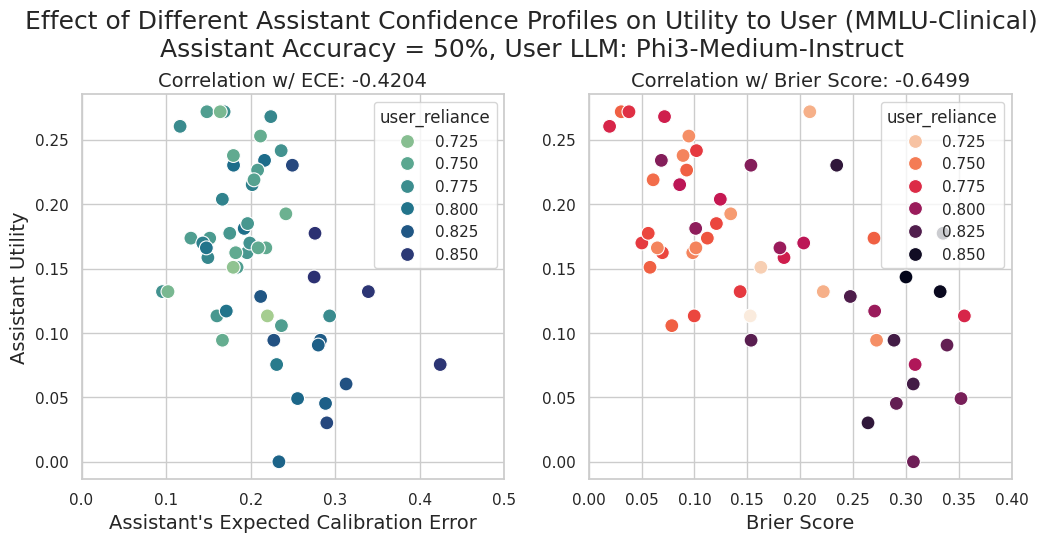

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr

sns.set(style="whitegrid")
df = pd.DataFrame.from_dict(all_results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"Effect of Different Assistant Confidence Profiles on Utility to User ({DATASET_TO_DISPLAY_NAME[dataset]})\nAssistant Accuracy = {assistant_acc:.0%}, User LLM: {LLM_TO_DISPLAY_NAME[user_llm]}", fontsize=18, y=1.05)

sns.scatterplot(
    x="assistant_calibration_error", 
    y="assistant_utility", 
    hue="user_reliance", 
    #hue="fpr", 
    data=df, 
    ax=ax1,
    #sizes=(50, 300),
    #size=300,
    s=100,
    palette="crest", 
    #hue_norm=(0, 1), size_norm=(0, 1),
)
#sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
ax1.set_xlim(0, 0.5)
ax1.set_xlabel("Assistant's Expected Calibration Error", fontsize=14)
ax1.set_ylabel("Assistant Utility", fontsize=14)
corr = spearmanr(df.assistant_calibration_error, df.assistant_utility)
ax1.set_title(f"Correlation w/ ECE: {corr.correlation:.4f}", fontsize=14)

sns.scatterplot(
    x="brier_score", 
    y="assistant_utility", 
    hue="user_reliance", 
    #hue="fpr", 
    data=df, 
    ax=ax2,
    s=100,
    palette="rocket_r", 
    #hue_norm=(0, 1), size_norm=(0, 1),

)
#sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
#ax2.legend([],[], frameon=False)
ax2.set_xlim(0, 0.4)
ax2.set_xlabel("Brier Score", fontsize=14)
ax2.set_ylabel("")
corr = spearmanr(df.brier_score, df.assistant_utility)
ax2.set_title(f"Correlation w/ Brier Score: {corr.correlation:.4f}", fontsize=14)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], str(point['val']).replace('_', '\n'), fontdict={"size": 10})

#label_point(df.confidence_margin, df.assistant_utility, df.experiment_str, plt.gca()) 


/tmp/ipykernel_55758/1813301025.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


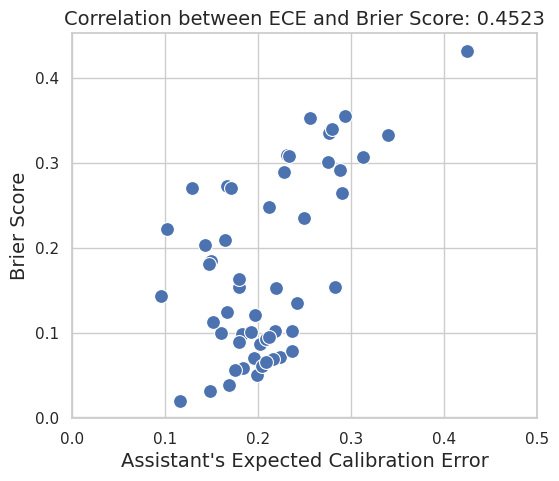

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr

sns.set(style="whitegrid")
df = pd.DataFrame.from_dict(all_results)

fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    x="assistant_calibration_error", 
    y="brier_score", 
    #hue="fpr", 
    data=df, 
    ax=ax,
    #sizes=(50, 300),
    #size=300,
    s=100,
    palette="crest", 
    #hue_norm=(0, 1), size_norm=(0, 1),
)
#sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(0, 0.5)
ax.set_xlabel("Assistant's Expected Calibration Error", fontsize=14)
ax.set_ylabel("Brier Score", fontsize=14)
corr = spearmanr(df.assistant_calibration_error, df.brier_score)
ax.set_title(f"Correlation between ECE and Brier Score: {corr.correlation:.4f}", fontsize=14)

plt.show()

5


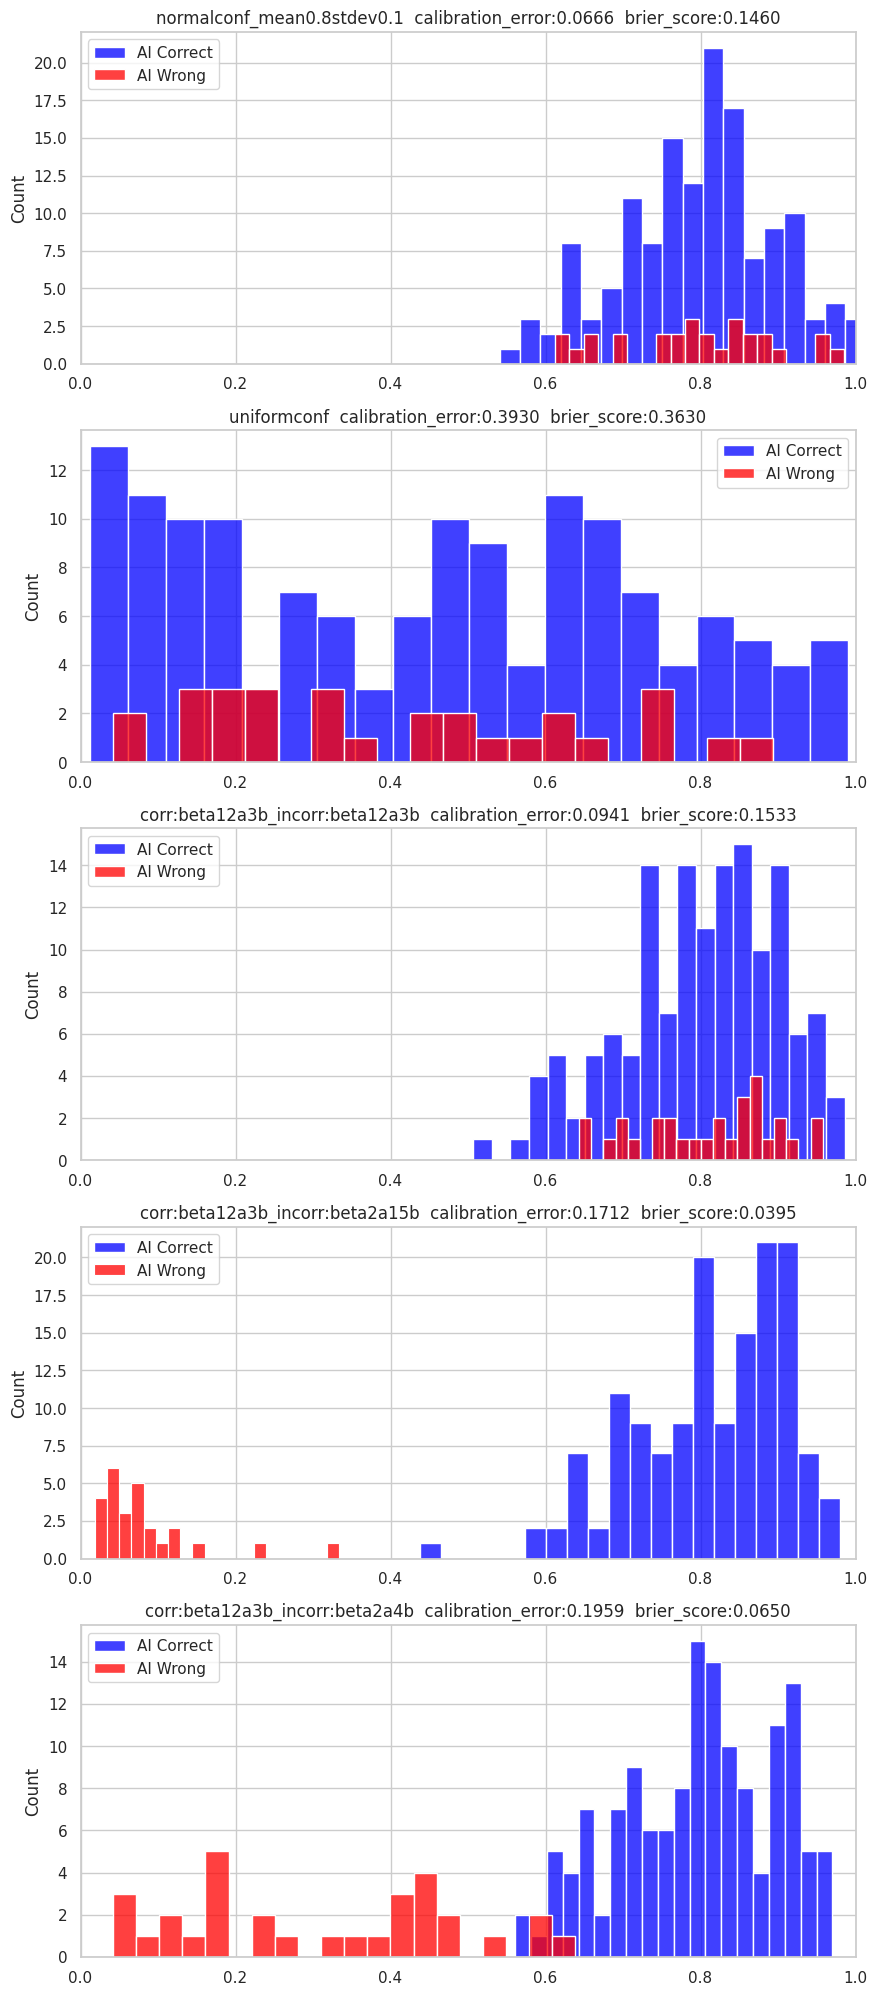

In [29]:
# For each experiment, plot histogram of AI confidences when AI was correct and when AI was wrong
fig, ax = plt.subplots(len(all_results[:5]), 1, figsize=(10, 5*len(all_results[:5])))
print(len(ax))
for i, exp in enumerate(all_results[:5]):
    #fig, ax = plt.subplots(figsize=(8, 4))
    ai_correct_confidences = [r['assistant_conf'] for r in exp['rollout_results'] if r['assistant_is_correct']]
    ai_wrong_confidences = [r['assistant_conf'] for r in exp['rollout_results'] if not r['assistant_is_correct']]
    sns.histplot(ai_correct_confidences, color="blue", ax=ax[i], bins=20, label="AI Correct")
    sns.histplot(ai_wrong_confidences, color="red", ax=ax[i], bins=20, label="AI Wrong")
    plot_title = exp['experiment_str'].replace('\n', '-') + f"  calibration_error:{exp['assistant_calibration_error']:.4f}  brier_score:{exp['brier_score']:.4f}"
    ax[i].set_title(plot_title)
    ax[i].set_xlim(0, 1)
    ax[i].legend()
plt.show()

In [ ]:
import os
import json

LLM_TO_DISPLAYNAME = {
    "mistral_7b_instruct": "Mistral-7B-Instruct",
    "llama3_8b_instruct": "LLaMA3-8B-Instruct",
}
llm_name = "llama3_8b_instruct"
assistant_accuracy = 0.5

experiments_dir = "/home/tejas/projects/messing_around/experiments/1stage_game/dataset-mmlu_clinical"
fn1 = os.path.join(experiments_dir, f"simulated_user-{llm_name}/assistant-{assistant_accuracy:.1f}acc_alwaysuniformconf.json")
fn2 = os.path.join(experiments_dir, f"simulated_user-{llm_name}-assistant_acc_aware/assistant-{assistant_accuracy:.1f}acc_alwaysuniformconf.json")

with open(os.path.join(experiments_dir, fn1), "r") as f:
    exp1 = json.load(f)
    exp1_results = exp1['rollout_results']

with open(os.path.join(experiments_dir, fn2), "r") as f:
    exp2 = json.load(f)
    exp2_results = exp2['rollout_results']

import seaborn as sns
import matplotlib.pyplot as plt

exp1_reliances, exp2_reliances = [], []
for i in range(10):
    exp1_filtered_results = [r for r in exp1_results if r['assistant_conf'] >= i/10 and r['assistant_conf'] < (i+1)/10]
    exp2_filtered_results = [r for r in exp2_results if r['assistant_conf'] >= i/10 and r['assistant_conf'] < (i+1)/10]
    exp1_reliance = len([r for r in exp1_filtered_results if r['user_agrees_with_assistant']]) / len(exp1_filtered_results)
    exp2_reliance = len([r for r in exp2_filtered_results if r['user_agrees_with_assistant']]) / len(exp2_filtered_results)
    exp1_reliances.append(exp1_reliance)
    exp2_reliances.append(exp2_reliance)

fig, ax = plt.subplots(figsize=(6, 4))
plt.title(f"User LLM: {LLM_TO_DISPLAYNAME[llm_name]}, relying on assistant with accuracy {assistant_accuracy:.0%}")
sns.lineplot(x=[i/10+0.05 for i in range(10)], y=exp1_reliances, label="Assistant accuracy not shown", ax=ax, marker='o', markersize=10)
sns.lineplot(x=[i/10+0.05 for i in range(10)], y=exp2_reliances, label="Assistant accuracy shown", ax=ax, marker='o', markersize=10)
ax.set_xlabel("Assistant confidence", fontsize=12)
ax.set_ylabel("User reliance on assistant", fontsize=12)
plt.show()

In [ ]:
import os
import json

LLM_TO_DISPLAYNAME = {
    "mistral_7b_instruct": "Mistral-7B-Instruct",
    "llama3_8b_instruct": "LLaMA3-8B-Instruct",
}
llm_name = "mistral_7b_instruct"

experiments_dir = "/home/tejas/projects/messing_around/experiments/1stage_game/dataset-mmlu_clinical"

def calculate_reliance(assistant_acc):
    fn = os.path.join(experiments_dir, f"simulated_user-{llm_name}-assistant_acc_aware/assistant-{assistant_acc:.1f}acc_alwaysuniformconf.json")
    with open(os.path.join(experiments_dir, fn), "r") as f:
        exp = json.load(f)
        exp_results = exp['rollout_results']

    exp_reliances = []
    for i in range(10):
        exp_filtered_results = [r for r in exp_results if r['assistant_conf'] >= i/10 and r['assistant_conf'] < (i+1)/10]
        exp_reliance = len([r for r in exp_filtered_results if r['user_agrees_with_assistant']]) / len(exp_filtered_results)
        exp_reliances.append(exp_reliance)
    return exp_reliances

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
plt.title(f"User LLM: {LLM_TO_DISPLAYNAME[llm_name]}, relying on assistant with accuracy shown")
for assistant_accuracy in [0.5, 0.6, 0.7, 0.8, 0.9]:
    exp_reliances = calculate_reliance(assistant_accuracy)
    sns.lineplot(
        x=[i/10+0.05 for i in range(10)], 
        y=exp_reliances, 
        label=f"Assistant accuracy: {assistant_accuracy:.0%}", 
        ax=ax, 
        marker='o', markersize=5
    ) 

ax.set_xlabel("Assistant confidence", fontsize=12)
ax.set_ylabel("User reliance on assistant", fontsize=12)
plt.show()

In [ ]:
import os
import json

LLM_TO_DISPLAYNAME = {
    "mistral_7b_instruct": "Mistral-7B-Instruct",
    "llama3_8b_instruct": "LLaMA3-8B-Instruct",
}
llm_name = "llama3_8b_instruct"

experiments_dir = "/home/tejas/projects/messing_around/experiments/1stage_game/dataset-mmlu_clinical"

def calculate_fpr(results):
    fp = sum([not r['assistant_is_correct'] and r['user_agrees_with_assistant'] for r in results])
    tn = sum([not r['assistant_is_correct'] and not r['user_agrees_with_assistant'] for r in results])
    print(fp, tn)
    if fp + tn == 0:
        return 0
    return fp / (fp + tn)

def plot_reliance(fn, label, color, linestyle):
    with open(os.path.join(experiments_dir, fn), "r") as f:
        exp = json.load(f)
        exp_results = exp['rollout_results']

    exp_reliances = []
    for i in range(10):
        exp_filtered_results = [r for r in exp_results if r['assistant_conf'] >= i/10 and r['assistant_conf'] < (i+1)/10]
        exp_reliance = len([r for r in exp_filtered_results if r['user_agrees_with_assistant']]) / len(exp_filtered_results)
        exp_reliances.append(exp_reliance)
    
    sns.lineplot(
        x=[i/10+0.05 for i in range(10)], 
        y=exp_reliances, 
        label=label, 
        ax=ax, 
        marker='o', linestyle=linestyle, color=color, markersize=5
    )

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
plt.title(f"User LLM: {LLM_TO_DISPLAYNAME[llm_name]}")

plot_reliance(
    fn=os.path.join(experiments_dir, f"simulated_user-{llm_name}/assistant-0.8acc_alwaysuniformconf.json"), 
    label="AI acc not shown, numerical expression", color='red', linestyle='--')
plot_reliance(
    fn=os.path.join(experiments_dir, f"simulated_user-{llm_name}/assistant-0.8acc_alwaysuniformconf_linguisticexpression.json"),
    label="AI acc not shown, linguistic expression", color='blue', linestyle='--')
plot_reliance(
    fn=os.path.join(experiments_dir, f"simulated_user-{llm_name}-assistant_acc_aware/assistant-0.8acc_alwaysuniformconf.json"),
    label="AI acc shown, numerical expression", color='red', linestyle='-')
plot_reliance(
    fn=os.path.join(experiments_dir, f"simulated_user-{llm_name}-assistant_acc_aware/assistant-0.8acc_alwaysuniformconf_linguisticexpression.json"),
    label="AI acc shown, linguistic expression", color='blue', linestyle='-')


ax.set_xlabel("Assistant confidence", fontsize=14)
ax.set_ylabel("User reliance on assistant", fontsize=14)
plt.show()